# Module 07: Loss Functions

**Measuring How Wrong the Model Is**

---

## Objectives

By the end of this notebook, you will:
- Understand what loss functions are and why they matter
- Master MSE, MAE for regression
- Master Binary and Categorical Cross-Entropy for classification
- Implement loss functions from scratch
- Know when to use which loss function

**Prerequisites:** [Module 05 - Activation Functions](../05_activation_functions/05_activation_functions.ipynb)

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

# Part 1: What is a Loss Function?

---

## 1.1 The Role of Loss Functions

A **loss function** (also called cost function or objective function) measures how far the model's predictions are from the actual values.

**Training Goal:** Minimize the loss function

$$\text{Optimal Parameters} = \arg\min_{\theta} L(y_{\text{true}}, y_{\text{pred}})$$

The loss function is what makes learning possible - it tells us:
1. **How wrong** the model is
2. **Which direction** to adjust parameters (via gradients)

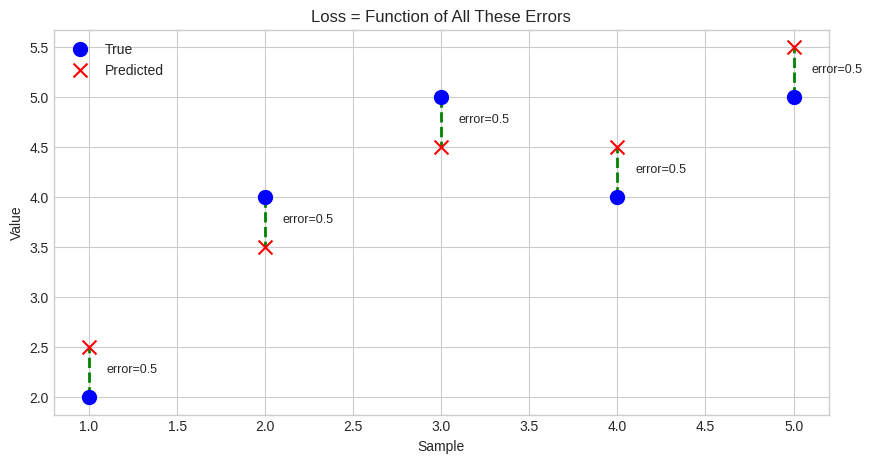

In [2]:
# Simple visualization of loss
fig, ax = plt.subplots(figsize=(10, 5))

# True values and predictions
x = np.array([1, 2, 3, 4, 5])
y_true = np.array([2, 4, 5, 4, 5])
y_pred = np.array([2.5, 3.5, 4.5, 4.5, 5.5])

ax.scatter(x, y_true, s=100, c='blue', label='True', zorder=5)
ax.scatter(x, y_pred, s=100, c='red', marker='x', label='Predicted', zorder=5)

# Show errors
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y_true[i], y_pred[i]], 'g--', linewidth=2)
    ax.annotate(f'error={abs(y_true[i]-y_pred[i]):.1f}',
                xy=(x[i]+0.1, (y_true[i]+y_pred[i])/2), fontsize=9)

ax.set_xlabel('Sample')
ax.set_ylabel('Value')
ax.set_title('Loss = Function of All These Errors')
ax.legend()
plt.show()

## 1.2 Properties of Good Loss Functions

A good loss function should be:
1. **Differentiable** - We need gradients for optimization
2. **Meaningful** - Low loss = good performance
3. **Task-appropriate** - Different tasks need different losses

---

# Part 2: Regression Loss Functions

---

## 2.1 Mean Squared Error (MSE)

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Properties:**
- Squares the errors (always positive)
- Penalizes large errors more than small ones
- Units are squared (if predicting meters, loss is in meters^2)

In [3]:
def mse_loss(y_true, y_pred):
    """Mean Squared Error from scratch."""
    return np.mean((y_true - y_pred) ** 2)

# Example
y_true = np.array([3, 5, 2.5, 7])
y_pred = np.array([2.5, 5, 4, 8])

# Step by step
errors = y_true - y_pred
squared_errors = errors ** 2
mse = np.mean(squared_errors)

print(f"True values:    {y_true}")
print(f"Predictions:    {y_pred}")
print(f"Errors:         {errors}")
print(f"Squared errors: {squared_errors}")
print(f"MSE:            {mse:.4f}")

True values:    [3.  5.  2.5 7. ]
Predictions:    [2.5 5.  4.  8. ]
Errors:         [ 0.5  0.  -1.5 -1. ]
Squared errors: [0.25 0.   2.25 1.  ]
MSE:            0.8750


In [4]:
# MSE gradient
# d(MSE)/d(y_pred) = -2/n * (y_true - y_pred) = 2/n * (y_pred - y_true)

def mse_gradient(y_true, y_pred):
    """Gradient of MSE with respect to predictions."""
    n = len(y_true)
    return 2/n * (y_pred - y_true)

gradient = mse_gradient(y_true, y_pred)
print(f"MSE Gradient: {gradient}")
print("Positive gradient = prediction too high, need to decrease")
print("Negative gradient = prediction too low, need to increase")

MSE Gradient: [-0.25  0.    0.75  0.5 ]
Positive gradient = prediction too high, need to decrease
Negative gradient = prediction too low, need to increase


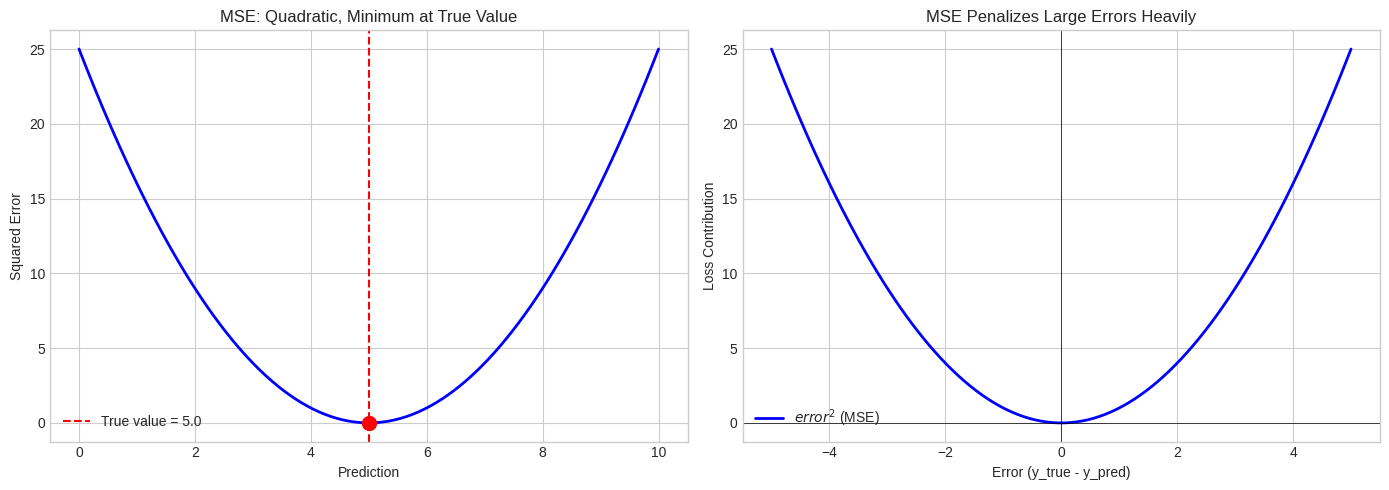

In [5]:
# Visualize MSE loss landscape
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Single prediction
ax = axes[0]
y_true_single = 5.0
predictions = np.linspace(0, 10, 100)
losses = (predictions - y_true_single) ** 2

ax.plot(predictions, losses, 'b-', linewidth=2)
ax.axvline(x=y_true_single, color='red', linestyle='--', label=f'True value = {y_true_single}')
ax.scatter([y_true_single], [0], c='red', s=100, zorder=5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Squared Error')
ax.set_title('MSE: Quadratic, Minimum at True Value')
ax.legend()

# Error distribution comparison
ax = axes[1]
errors = np.linspace(-5, 5, 100)
squared_errors = errors ** 2
ax.plot(errors, squared_errors, 'b-', linewidth=2, label='$error^2$ (MSE)')
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Error (y_true - y_pred)')
ax.set_ylabel('Loss Contribution')
ax.set_title('MSE Penalizes Large Errors Heavily')
ax.legend()

plt.tight_layout()
plt.show()

## 2.2 Mean Absolute Error (MAE)

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

**Properties:**
- Uses absolute value instead of square
- More robust to outliers than MSE
- Units match the target variable

In [6]:
def mae_loss(y_true, y_pred):
    """Mean Absolute Error from scratch."""
    return np.mean(np.abs(y_true - y_pred))

# Compare MSE and MAE with outliers
y_true = np.array([3, 5, 2.5, 7])
y_pred_good = np.array([3.1, 5.1, 2.4, 7.1])  # Small errors
y_pred_outlier = np.array([3.1, 5.1, 2.4, 15])  # One large error

print("Without outlier:")
print(f"  MSE = {mse_loss(y_true, y_pred_good):.4f}")
print(f"  MAE = {mae_loss(y_true, y_pred_good):.4f}")

print("\nWith outlier:")
print(f"  MSE = {mse_loss(y_true, y_pred_outlier):.4f}")
print(f"  MAE = {mae_loss(y_true, y_pred_outlier):.4f}")

print("\nMSE increases much more with outliers!")

Without outlier:
  MSE = 0.0100
  MAE = 0.1000

With outlier:
  MSE = 16.0075
  MAE = 2.0750

MSE increases much more with outliers!


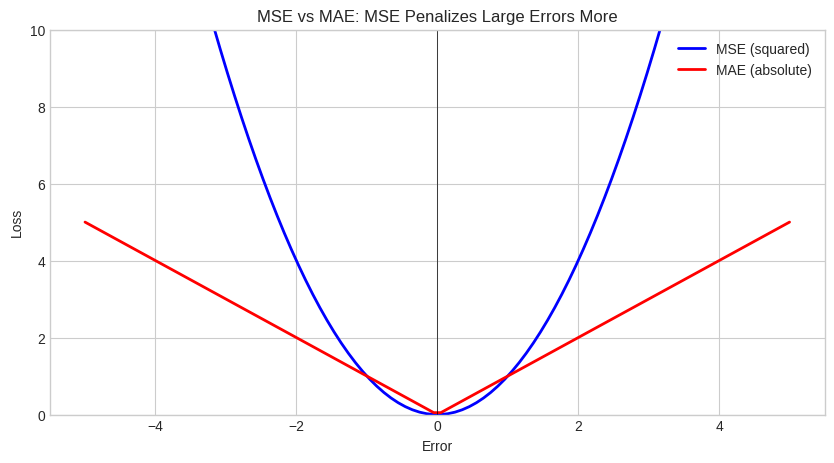

In [7]:
# Compare MSE vs MAE
fig, ax = plt.subplots(figsize=(10, 5))

errors = np.linspace(-5, 5, 100)
ax.plot(errors, errors ** 2, 'b-', linewidth=2, label='MSE (squared)')
ax.plot(errors, np.abs(errors), 'r-', linewidth=2, label='MAE (absolute)')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Error')
ax.set_ylabel('Loss')
ax.set_title('MSE vs MAE: MSE Penalizes Large Errors More')
ax.legend()
ax.set_ylim(0, 10)
plt.show()

## 2.3 Huber Loss

Combines the best of MSE and MAE:

$$L_\delta(y, \hat{y}) = \begin{cases} \frac{1}{2}(y - \hat{y})^2 & \text{if } |y - \hat{y}| \leq \delta \\ \delta |y - \hat{y}| - \frac{1}{2}\delta^2 & \text{otherwise} \end{cases}$$

- Quadratic for small errors (like MSE)
- Linear for large errors (like MAE, robust to outliers)

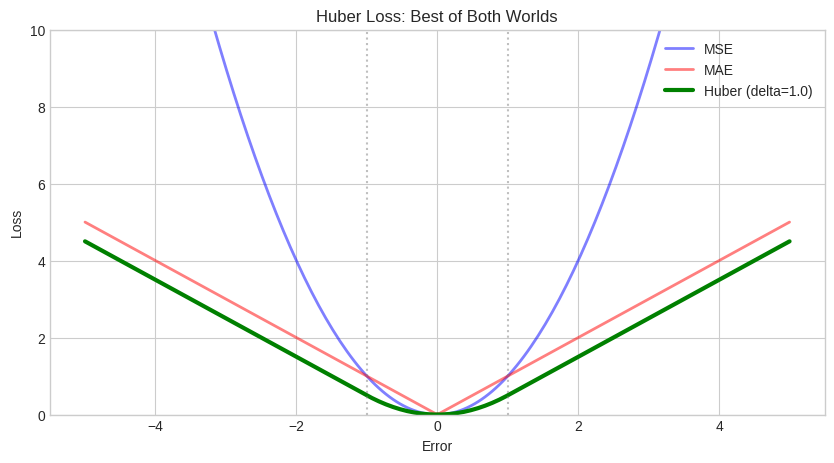

In [8]:
def huber_loss(y_true, y_pred, delta=1.0):
    """Huber loss from scratch."""
    error = np.abs(y_true - y_pred)
    is_small_error = error <= delta

    quadratic = 0.5 * error ** 2
    linear = delta * error - 0.5 * delta ** 2

    return np.mean(np.where(is_small_error, quadratic, linear))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))

errors = np.linspace(-5, 5, 200)
delta = 1.0

mse_vals = errors ** 2
mae_vals = np.abs(errors)
huber_vals = np.where(np.abs(errors) <= delta,
                       0.5 * errors ** 2,
                       delta * np.abs(errors) - 0.5 * delta ** 2)

ax.plot(errors, mse_vals, 'b-', linewidth=2, alpha=0.5, label='MSE')
ax.plot(errors, mae_vals, 'r-', linewidth=2, alpha=0.5, label='MAE')
ax.plot(errors, huber_vals, 'g-', linewidth=3, label=f'Huber (delta={delta})')

ax.axvline(x=delta, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=-delta, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Error')
ax.set_ylabel('Loss')
ax.set_title('Huber Loss: Best of Both Worlds')
ax.legend()
ax.set_ylim(0, 10)
plt.show()

---

# Part 3: Classification Loss Functions

---

## 3.1 Binary Cross-Entropy (BCE)

For binary classification (0 or 1):

$$\text{BCE} = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$

Where $\hat{y}_i$ is the predicted probability (between 0 and 1).

### Intuition

- When $y = 1$: Loss = $-\log(\hat{y})$. We want $\hat{y}$ close to 1.
- When $y = 0$: Loss = $-\log(1-\hat{y})$. We want $\hat{y}$ close to 0.

The negative log makes:
- Correct confident predictions (0.99 for class 1) have low loss
- Wrong confident predictions (0.99 for class 0) have HIGH loss

In [9]:
def binary_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """Binary Cross-Entropy from scratch."""
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

# Example
y_true = np.array([1, 0, 1, 0])
y_pred_good = np.array([0.9, 0.1, 0.8, 0.2])  # Good predictions
y_pred_bad = np.array([0.1, 0.9, 0.2, 0.8])   # Bad predictions

print(f"Good predictions:")
print(f"  True: {y_true}")
print(f"  Pred: {y_pred_good}")
print(f"  BCE:  {binary_cross_entropy(y_true, y_pred_good):.4f}")

print(f"\nBad predictions:")
print(f"  True: {y_true}")
print(f"  Pred: {y_pred_bad}")
print(f"  BCE:  {binary_cross_entropy(y_true, y_pred_bad):.4f}")

Good predictions:
  True: [1 0 1 0]
  Pred: [0.9 0.1 0.8 0.2]
  BCE:  0.1643

Bad predictions:
  True: [1 0 1 0]
  Pred: [0.1 0.9 0.2 0.8]
  BCE:  1.9560


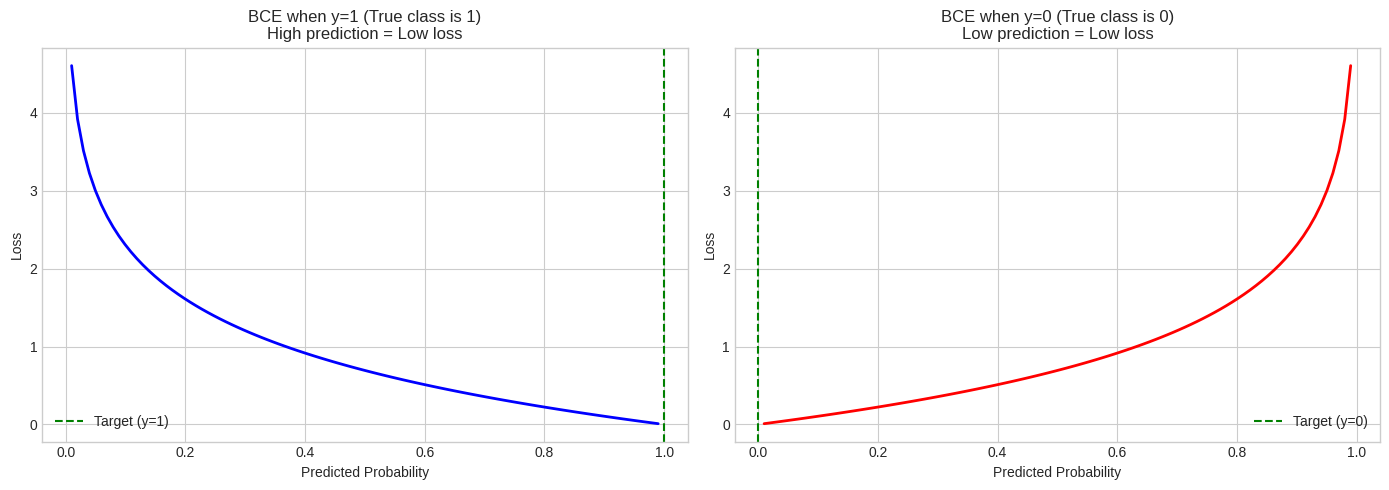

In [10]:
# Visualize BCE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

p = np.linspace(0.01, 0.99, 100)

# When y=1
ax = axes[0]
loss_y1 = -np.log(p)
ax.plot(p, loss_y1, 'b-', linewidth=2)
ax.axvline(x=1, color='green', linestyle='--', label='Target (y=1)')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Loss')
ax.set_title('BCE when y=1 (True class is 1)\nHigh prediction = Low loss')
ax.legend()

# When y=0
ax = axes[1]
loss_y0 = -np.log(1 - p)
ax.plot(p, loss_y0, 'r-', linewidth=2)
ax.axvline(x=0, color='green', linestyle='--', label='Target (y=0)')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Loss')
ax.set_title('BCE when y=0 (True class is 0)\nLow prediction = Low loss')
ax.legend()

plt.tight_layout()
plt.show()

### Why Not MSE for Classification?

MSE can be used for classification but BCE is better because:
1. **Stronger gradient** when prediction is very wrong
2. **Probabilistic interpretation** - minimizing BCE is maximum likelihood
3. **Works better with sigmoid** outputs

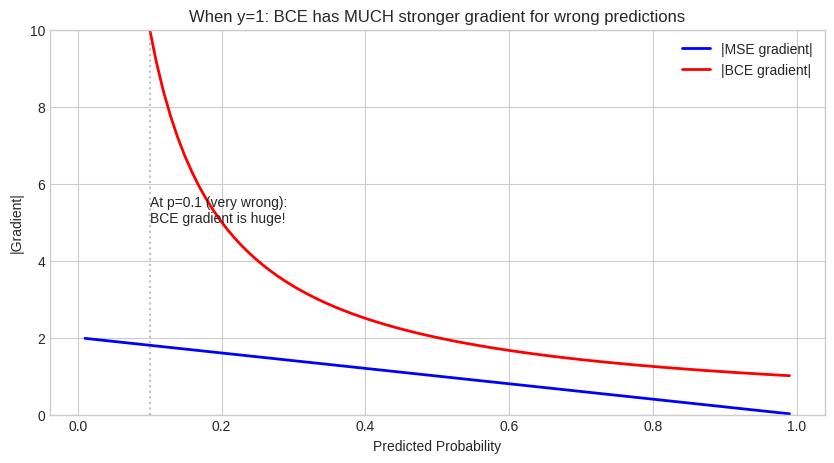

In [11]:
# Compare BCE vs MSE gradients
fig, ax = plt.subplots(figsize=(10, 5))

p = np.linspace(0.01, 0.99, 100)

# Gradients when y=1 (we want p close to 1)
mse_grad = 2 * (p - 1)  # d/dp of (p-1)^2
bce_grad = -1/p          # d/dp of -log(p)

ax.plot(p, np.abs(mse_grad), 'b-', linewidth=2, label='|MSE gradient|')
ax.plot(p, np.abs(bce_grad), 'r-', linewidth=2, label='|BCE gradient|')

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('|Gradient|')
ax.set_title('When y=1: BCE has MUCH stronger gradient for wrong predictions')
ax.legend()
ax.set_ylim(0, 10)
ax.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5)
ax.annotate('At p=0.1 (very wrong):\nBCE gradient is huge!',
            xy=(0.1, 5), fontsize=10)
plt.show()

## 3.2 Categorical Cross-Entropy

For multi-class classification (K classes):

$$\text{CCE} = -\sum_{i=1}^{n} \sum_{c=1}^{K} y_{i,c} \log(\hat{y}_{i,c})$$

Where $y_{i,c}$ is 1 if sample i belongs to class c (one-hot encoded).

In [12]:
def categorical_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """Categorical Cross-Entropy from scratch."""
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# Example: 3 classes
# One-hot encoded true labels
y_true = np.array([
    [1, 0, 0],  # Class 0
    [0, 1, 0],  # Class 1
    [0, 0, 1],  # Class 2
])

# Good predictions (high probability for correct class)
y_pred_good = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.8, 0.1],
    [0.05, 0.05, 0.9],
])

# Bad predictions
y_pred_bad = np.array([
    [0.1, 0.45, 0.45],
    [0.4, 0.3, 0.3],
    [0.5, 0.4, 0.1],
])

print(f"Good predictions CCE: {categorical_cross_entropy(y_true, y_pred_good):.4f}")
print(f"Bad predictions CCE: {categorical_cross_entropy(y_true, y_pred_bad):.4f}")

Good predictions CCE: 0.1446
Bad predictions CCE: 1.9364


## 3.3 Negative Log-Likelihood (NLL)

When targets are class indices (not one-hot):

$$\text{NLL} = -\frac{1}{n} \sum_{i=1}^{n} \log(\hat{y}_{i, c_i})$$

Where $c_i$ is the true class index for sample i.

In [13]:
def nll_loss(y_true_classes, y_pred_probs, epsilon=1e-15):
    """Negative Log-Likelihood from scratch."""
    n = len(y_true_classes)
    y_pred_probs = np.clip(y_pred_probs, epsilon, 1 - epsilon)

    # For each sample, get the probability of the true class
    probs_of_true_class = y_pred_probs[np.arange(n), y_true_classes]

    return -np.mean(np.log(probs_of_true_class))

# Example
y_true_idx = np.array([0, 1, 2])  # Class indices
y_pred = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.8, 0.1],
    [0.05, 0.05, 0.9],
])

print(f"NLL: {nll_loss(y_true_idx, y_pred):.4f}")

NLL: 0.1446


---

# Part 4: PyTorch Loss Functions

---

In [14]:
# Regression losses
print("=== Regression Losses ===")

y_true = torch.tensor([3.0, 5.0, 2.5, 7.0])
y_pred = torch.tensor([2.5, 5.0, 4.0, 8.0])

mse = nn.MSELoss()
mae = nn.L1Loss()
huber = nn.HuberLoss(delta=1.0)

print(f"MSE:   {mse(y_pred, y_true).item():.4f}")
print(f"MAE:   {mae(y_pred, y_true).item():.4f}")
print(f"Huber: {huber(y_pred, y_true).item():.4f}")

=== Regression Losses ===
MSE:   0.8750
MAE:   0.7500
Huber: 0.4062


In [15]:
# Binary classification
print("=== Binary Classification Losses ===")

y_true = torch.tensor([1.0, 0.0, 1.0, 0.0])
y_pred = torch.tensor([0.9, 0.1, 0.8, 0.2])  # Probabilities

bce = nn.BCELoss()
print(f"BCE: {bce(y_pred, y_true).item():.4f}")

# BCEWithLogits expects raw scores, applies sigmoid internally
logits = torch.tensor([2.0, -2.0, 1.5, -1.5])  # Before sigmoid
bce_logits = nn.BCEWithLogitsLoss()
print(f"BCEWithLogits: {bce_logits(logits, y_true).item():.4f}")

=== Binary Classification Losses ===
BCE: 0.1643
BCEWithLogits: 0.1642


In [16]:
# Multi-class classification
print("=== Multi-class Classification Losses ===")

# 3 samples, 4 classes
logits = torch.tensor([[2.0, 1.0, 0.1, -1.0],   # Predicts class 0
                       [0.5, 2.5, 0.2, 0.1],    # Predicts class 1
                       [-0.5, 0.1, 3.0, 0.5]])  # Predicts class 2

y_true = torch.tensor([0, 1, 2])  # Class indices

# CrossEntropyLoss = LogSoftmax + NLLLoss
ce = nn.CrossEntropyLoss()
print(f"CrossEntropy: {ce(logits, y_true).item():.4f}")

# Manual equivalent
log_softmax = nn.LogSoftmax(dim=1)
nll = nn.NLLLoss()
print(f"LogSoftmax + NLL: {nll(log_softmax(logits), y_true).item():.4f}")

=== Multi-class Classification Losses ===
CrossEntropy: 0.2955
LogSoftmax + NLL: 0.2955


### Important Note: CrossEntropyLoss in PyTorch

PyTorch's `nn.CrossEntropyLoss` expects:
- **Raw logits** (before softmax)
- **Class indices** (not one-hot encoded)

It combines `nn.LogSoftmax` and `nn.NLLLoss` internally.

---

# Part 5: Choosing the Right Loss Function

---

| Task | Loss Function | PyTorch Class |
|------|---------------|---------------|
| Regression | MSE | `nn.MSELoss()` |
| Regression (outliers) | MAE or Huber | `nn.L1Loss()`, `nn.HuberLoss()` |
| Binary Classification | BCE | `nn.BCELoss()` or `nn.BCEWithLogitsLoss()` |
| Multi-class Classification | Cross-Entropy | `nn.CrossEntropyLoss()` |
| Multi-label Classification | BCE | `nn.BCEWithLogitsLoss()` |

### Common Mistakes

1. **Applying softmax before CrossEntropyLoss**
   - CrossEntropyLoss includes softmax
   - Applying twice causes numerical issues

2. **Using BCELoss with logits**
   - BCELoss expects probabilities (0-1)
   - Use BCEWithLogitsLoss for raw scores

3. **Using MSE for classification**
   - Works but suboptimal gradients
   - Use Cross-Entropy instead

---

# Key Points Summary

---

## Regression Losses
- **MSE**: Penalizes large errors heavily, differentiable
- **MAE**: Robust to outliers, constant gradient
- **Huber**: Best of both (quadratic small, linear large)

## Classification Losses  
- **BCE**: Binary classification, expects probabilities
- **Cross-Entropy**: Multi-class, combines softmax + NLL
- Strong gradients when predictions are wrong

## PyTorch Tips
- Use `BCEWithLogitsLoss` for numerical stability
- `CrossEntropyLoss` expects raw logits, not softmax output
- Class indices for targets, not one-hot

---

# Interview Tips

---

## Common Questions

**Q: What is a loss function?**
A: A loss function measures how far the model's predictions are from the actual values. It's what we minimize during training. The gradients of the loss guide parameter updates.

**Q: When would you use MAE vs MSE?**
A: Use MSE when large errors are particularly bad and data is clean. Use MAE when you want robustness to outliers or when error units matter.

**Q: Why use cross-entropy instead of MSE for classification?**
A: Cross-entropy has stronger gradients when predictions are very wrong, making learning faster. It also has a probabilistic interpretation (maximum likelihood) and works better with softmax/sigmoid outputs.

**Q: What's the difference between BCELoss and BCEWithLogitsLoss?**
A: BCELoss expects probabilities (after sigmoid). BCEWithLogitsLoss expects raw scores (logits) and applies sigmoid internally. The latter is more numerically stable.

---

# Practice Exercises

---

## Exercise 1: Derive BCE Gradient

Derive the gradient of BCE loss with respect to the prediction $\hat{y}$.

In [17]:
# BCE = -[y*log(p) + (1-y)*log(1-p)]
# d(BCE)/dp = ?

# Your derivation here

## Exercise 2: Implement Focal Loss

Focal Loss is used for imbalanced classification:
$$FL(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)$$

In [18]:
# Your implementation here
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    pass

## Solutions

In [19]:
# Exercise 1 Solution
print("Exercise 1: BCE Gradient")
print("""
BCE = -[y*log(p) + (1-y)*log(1-p)]

d(BCE)/dp = -[y * 1/p + (1-y) * (-1)/(1-p)]
          = -y/p + (1-y)/(1-p)
          = [-y(1-p) + (1-y)p] / [p(1-p)]
          = [-y + yp + p - yp] / [p(1-p)]
          = (p - y) / [p(1-p)]
""")

# Exercise 2 Solution
print("Exercise 2: Focal Loss")
def focal_loss_solution(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # p_t = p if y=1, else 1-p
    p_t = np.where(y_true == 1, y_pred, 1 - y_pred)
    alpha_t = np.where(y_true == 1, alpha, 1 - alpha)

    focal_weight = (1 - p_t) ** gamma
    focal = -alpha_t * focal_weight * np.log(p_t)

    return np.mean(focal)

y = np.array([1, 0, 1, 0])
p = np.array([0.9, 0.1, 0.8, 0.2])
print(f"Focal Loss: {focal_loss_solution(y, p):.4f}")

Exercise 1: BCE Gradient

BCE = -[y*log(p) + (1-y)*log(1-p)]

d(BCE)/dp = -[y * 1/p + (1-y) * (-1)/(1-p)]
          = -y/p + (1-y)/(1-p)
          = [-y(1-p) + (1-y)p] / [p(1-p)]
          = [-y + yp + p - yp] / [p(1-p)]
          = (p - y) / [p(1-p)]

Exercise 2: Focal Loss
Focal Loss: 0.0025


---

## Next Module: [08 - Gradient Descent](../08_gradient_descent/08_gradient_descent.ipynb)

Now that we understand loss functions, let's learn how to minimize them using gradient descent.